Draw the detector

C:\Users\ricca\AppData\Local\Temp\ipykernel_21548\4084950212.py:22: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  plt.gca().add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, 2990 - 2230,
C:\Users\ricca\AppData\Local\Temp\ipykernel_21548\4084950212.py:26: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  plt.gca().add_patch(plt.Rectangle((xactives[0][0], yplus['ymin']), xactives[-1][1] - xactives[0][0],
C:\Users\ricca\AppData\Local\Temp\ipykernel_21548\4084950212.py:28: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  plt.gca().add_patch(plt.Rectangle((xactives[0][0], yneg['ymin']), xactives[-1][1] - xactives[0][0],


Text(0.5, 1.0, 'Detector drawing')

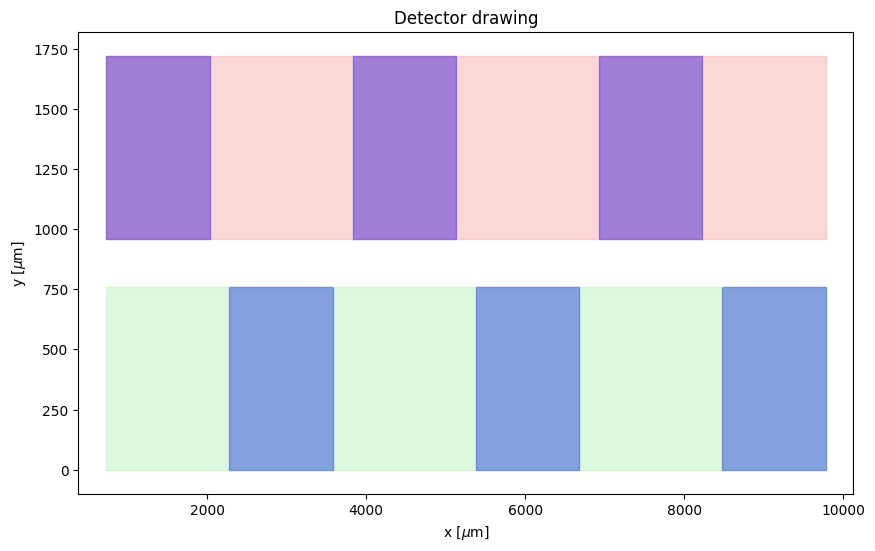

In [2]:
import matplotlib.pyplot as plt

# Define the active regions (in nm)
x = {'xmin': [i * 1550 + 480 for i in range(7)], 'xmax': [i * 1550 + 730 for i in range(7)]}
xactives = [(x['xmax'][i],x['xmin'][i+1]) for i in range(len(x['xmin'])-1)]
yactives = [(0, 2030-1270), (2230-1270, 2290-1270)]

# Define the additional y regions
yplus = {'ymin': 2230-1270, 'ymax': 2990-1270}
yneg = {'ymin': 0, 'ymax': 2030-1270}
y = [0, 2030-1270, 2230-1270, 2990-1270]

# Create the plot
plt.figure(figsize=(10, 6))

# Plot active regions
for i,xactive in enumerate(xactives):
    xmin, xmax = xactive
    for j,yactive in enumerate(yactives):
        ymin, ymax = yactive
        if (i%2==0 and j%2==1) or (i%2==1 and j%2==0):
            plt.gca().add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, 2990 - 2230,
                                        fill=True, edgecolor='blue', color='blue', alpha=0.5))

# Plot additional regions
plt.gca().add_patch(plt.Rectangle((xactives[0][0], yplus['ymin']), xactives[-1][1] - xactives[0][0],
                                yplus['ymax'] - yplus['ymin'], fill=True, edgecolor='red', color='lightcoral', alpha=0.3, label="yplus"))
plt.gca().add_patch(plt.Rectangle((xactives[0][0], yneg['ymin']), xactives[-1][1] - xactives[0][0],
                                yneg['ymax'] - yneg['ymin'], fill=True, edgecolor='green', color='lightgreen', alpha=0.3, label="yneg"))

# Set plot limits
plt.xlim(min(x['xmin']) - 100, max(x['xmax']) + 100)
plt.ylim(min(y) - 100, max(y) + 100)
# Labeling
plt.xlabel(r'x [$\mu$m]')
plt.ylabel(r'y [$\mu$m]')
plt.title('Detector drawing')

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import j1

MC Simulation

In [4]:
# Simulation Parameters
N_photons = int(1e7)  # Number of photons to simulate
detector_width = 1550 * 8 + 730  # Total width of the detector in micrometers
detector_height = 2990  # Total height of the detector in micrometers
distance_to_detector = 5000  # Distance from fiber to detector in micrometers
fiber_diameter = 8.2  # Diameter of the fiber in micrometers
wavelength = 1.555  # Wavelength of light in micrometers

# Constants
k = 2 * np.pi / wavelength  # Wavenumber
fiber_aperture_radius = fiber_diameter / 2  # Radius of the fiber aperture in micrometers

# Define angles to loop over
angles = np.linspace(-80, 80, 17)

# Initialize lists to store results
efficiencies = []
errors = []

# Loop over angles
for inclination_angle in angles:
    # Convert inclination angle to radians
    alpha = np.deg2rad(inclination_angle)

    # Generate random photon angles within the aperture
    theta = np.random.uniform(-np.pi/2, np.pi/2, N_photons)
    phi = np.random.uniform(0, 2*np.pi, N_photons)

    # Generate random positions within the fiber aperture
    r_aperture = np.random.uniform(0, fiber_aperture_radius, N_photons)
    phi_aperture = np.random.uniform(0, 2*np.pi, N_photons)
    x_aperture = r_aperture * np.cos(phi_aperture)
    y_aperture = r_aperture * np.sin(phi_aperture)

    # Rotate the positions by the inclination angle alpha
    z_hits = distance_to_detector * np.ones(N_photons)

    # Rotation matrices for inclination along the x-axis (affecting y and z)
    x_rotated = x_aperture * np.cos(alpha) - z_hits * np.sin(alpha)
    y_rotated = y_aperture
    z_rotated = x_aperture * np.sin(alpha) + z_hits * np.cos(alpha)

    # Project onto the detector plane
    x_hits = x_rotated + distance_to_detector * np.tan(theta) * np.cos(phi)
    y_hits = y_rotated + distance_to_detector * np.tan(theta) * np.sin(phi)

    # Calculate the intensity of the Airy pattern at the detector plane
    r = np.sqrt(x_hits**2 + y_hits**2)
    airy_pattern = (2 * j1(k * r * fiber_diameter / (2 * distance_to_detector)) / (k * r * fiber_diameter / (2 * distance_to_detector))) ** 2
    airy_pattern[np.isnan(airy_pattern)] = 0  # Handle division by zero
    airy_pattern /= airy_pattern.max()

    # Monte Carlo rejection sampling to accept photons based on Airy pattern
    acceptance = np.random.uniform(0, 1, N_photons)
    hits = acceptance <= airy_pattern

    # Update x and y positions with hits
    x_hits = x_hits[hits]  
    y_hits = y_hits[hits]

    # Calculate current center of the Airy pattern
    current_center_x = np.mean(x_hits)
    current_center_y = np.mean(y_hits)

    # Define the active regions (in micrometers)
    x = {'xmin': [i * 1550 + 480 for i in range(7)], 'xmax': [i * 1550 + 730 for i in range(7)]}
    xactives = [(x['xmax'][i], x['xmin'][i+1]) for i in range(len(x['xmin'])-1)]
    yactives = [(1270, 2030), (2230, 2290)]

    # Define additional y regions
    yplus = {'ymin': 2230, 'ymax': 2990}
    yneg = {'ymin': 1270, 'ymax': 2030}

    # Calculate target center of the detector
    target_center_x = (max(x['xmax']) + min(x['xmin'])) / 2
    target_center_y = detector_height / 2 + 1270/2

    # Apply offset to center the Airy pattern
    x_hits -= (current_center_x - target_center_x)
    y_hits -= (current_center_y - target_center_y)

    # Check if the photon hits the active areas on the detector
    hits_active_area = np.zeros_like(x_hits, dtype=bool)

    hits_active_area |= (
        (x_hits >= 730) &
        (x_hits <= 1550+480) &
        (y_hits >= 2230) &
        (y_hits <= 2990)
    )

    # Calculate the geometrical efficiency
    geometrical_efficiency = np.sum(hits_active_area) / N_photons

    # Calculate the standard error
    standard_error = np.sqrt(geometrical_efficiency * (1 - geometrical_efficiency) / N_photons)

    # Calculate 95% confidence interval
    confidence_interval = 1.96 * standard_error

    # Store the results
    efficiencies.append(geometrical_efficiency)
    errors.append(confidence_interval)

    print(f"Inclination Angle: {inclination_angle}°")
    print(f"Geometrical Efficiency: {geometrical_efficiency:.4f}")
    print(f"Standard Error: {standard_error:.4f}")
    print(f"95% Confidence Interval: ±{confidence_interval:.4f}")
    print()


Inclination Angle: -80.0°
Geometrical Efficiency: 0.0000
Standard Error: 0.0000
95% Confidence Interval: ±0.0000

Inclination Angle: -70.0°
Geometrical Efficiency: 0.0000
Standard Error: 0.0000
95% Confidence Interval: ±0.0000

Inclination Angle: -60.0°
Geometrical Efficiency: 0.0000
Standard Error: 0.0000
95% Confidence Interval: ±0.0000

Inclination Angle: -50.0°
Geometrical Efficiency: 0.0000
Standard Error: 0.0000
95% Confidence Interval: ±0.0000

Inclination Angle: -40.0°
Geometrical Efficiency: 0.0000
Standard Error: 0.0000
95% Confidence Interval: ±0.0000

Inclination Angle: -30.0°
Geometrical Efficiency: 0.0000
Standard Error: 0.0000
95% Confidence Interval: ±0.0000

Inclination Angle: -20.0°
Geometrical Efficiency: 0.0000
Standard Error: 0.0000
95% Confidence Interval: ±0.0000

Inclination Angle: -10.0°
Geometrical Efficiency: 0.0000
Standard Error: 0.0000
95% Confidence Interval: ±0.0000

Inclination Angle: 0.0°
Geometrical Efficiency: 0.0000
Standard Error: 0.0000
95% Confid

C:\Users\ricca\AppData\Local\Temp\ipykernel_21548\1426881553.py:10: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  plt.gca().add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, 2990 - 2230,
C:\Users\ricca\AppData\Local\Temp\ipykernel_21548\1426881553.py:13: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  plt.gca().add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, 2990 - 2230,


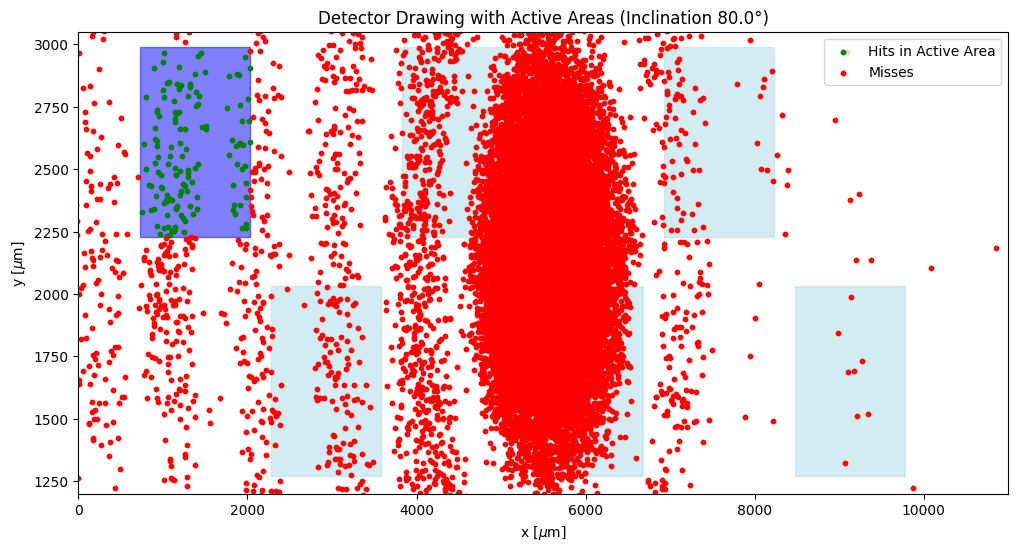

In [5]:
# Visualization (optional)
plt.figure(figsize=(12, 6))

# Plot active areas
for i,xactive in enumerate(xactives):
    xmin, xmax = xactive
    for j,yactive in enumerate(yactives):
        ymin, ymax = yactive
        if (i==0 and j==1):
            plt.gca().add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, 2990 - 2230,
                                    fill=True, edgecolor='blue', color='blue', alpha=0.5))
        elif (i%2==0 and j%2==1) or (i%2==1 and j%2==0):
            plt.gca().add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, 2990 - 2230,
                                    fill=True, edgecolor='lightblue', color='lightblue', alpha=0.5))
            
# Plot the hits
plt.scatter(x_hits[hits_active_area], y_hits[hits_active_area], s=10, c='green', label='Hits in Active Area')
plt.scatter(x_hits[~hits_active_area], y_hits[~hits_active_area], s=10, c='red', label='Misses')

# Set plot limits
plt.xlim(0, 11000)
plt.ylim(1200, 3050)

# Labeling
plt.xlabel(r'x [$\mu$m]')
plt.ylabel(r'y [$\mu$m]')
plt.title(f'Detector Drawing with Active Areas (Inclination {inclination_angle}°)')
plt.legend()
plt.show()

In [6]:
I_0 = 73.38798058620857*1e9

C:\Users\ricca\AppData\Local\Temp\ipykernel_21548\1773933058.py:4: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ko" (-> color='k'). The keyword argument will take precedence.
  axs[0].errorbar(angles, np.array(efficiencies), yerr=errors, fmt='ko', capsize=5, linestyle='', color='black', alpha=0.5)
C:\Users\ricca\AppData\Local\Temp\ipykernel_21548\1773933058.py:10: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ko" (-> color='k'). The keyword argument will take precedence.
  axs[1].errorbar(angles, np.array(efficiencies)*I_0, yerr=np.array(errors)*I_0, fmt='ko', capsize=5, linestyle='', color='black', alpha=0.5)


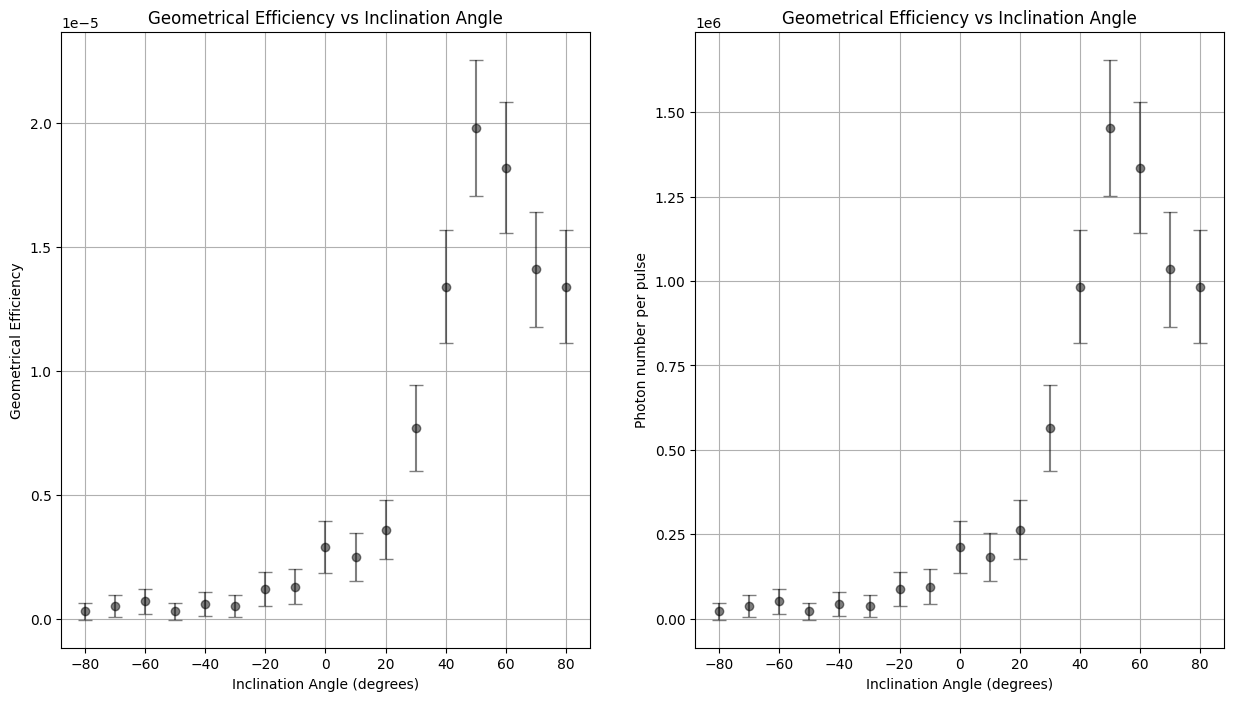

In [7]:
# Plot results

fig, axs = plt.subplots(1,2, figsize=(15,8))
axs[0].errorbar(angles, np.array(efficiencies), yerr=errors, fmt='ko', capsize=5, linestyle='', color='black', alpha=0.5)
axs[0].set_xlabel('Inclination Angle (degrees)')
axs[0].set_ylabel('Geometrical Efficiency')
axs[0].set_title('Geometrical Efficiency vs Inclination Angle')
axs[0].grid(True)

axs[1].errorbar(angles, np.array(efficiencies)*I_0, yerr=np.array(errors)*I_0, fmt='ko', capsize=5, linestyle='', color='black', alpha=0.5)
axs[1].set_xlabel('Inclination Angle (degrees)')
axs[1].set_ylabel('Photon number per pulse')
axs[1].set_title('Geometrical Efficiency vs Inclination Angle')
axs[1].grid(True)
#axs[1].text(-30,0.35*1e6,f'Quota: {distance_to_detector*1e-6} [m]', fontsize='large')

Stesso angolo (10°) ma quote diverse

In [8]:
eff_means_q, eff_stds_q = [], []
quote = np.linspace(100,10000,20,dtype=int)

for quota in quote:
    
    # Parameters
    N_photons = int(1e7)  # Number of photons to simulate
    detector_width = (1550 * 8 + 730)  # Total width of the detector in microm
    detector_height = (2990 - 1270)  # Total height of the detector in microm
    distance_to_detector = quota  # Distance from fiber to detector in microm
    fiber_diameter = 8.2  # Diameter of the fiber in microm
    wavelength = 1.555  # Wavelength of light in microm
    inclination_angle=10
    # Constants
    k = 2 * np.pi / wavelength  # Wavenumber
    fiber_aperture_radius = fiber_diameter / 2  # Radius of the fiber aperture in nm

    # Convert inclination angle to radians
    alpha = np.deg2rad(inclination_angle)

    # Generate random photon angles within the aperture
    theta = np.random.uniform(-np.pi / 2, np.pi / 2, N_photons)
    phi = np.random.uniform(0, 2 * np.pi, N_photons)

    # Generate random positions within the fiber aperture
    r_aperture = np.random.uniform(0, fiber_aperture_radius, N_photons)
    phi_aperture = np.random.uniform(0, 2 * np.pi, N_photons)
    x_aperture = r_aperture * np.cos(phi_aperture)
    y_aperture = r_aperture * np.sin(phi_aperture)

    # Rotate the positions by the inclination angle alpha
    z_hits = distance_to_detector * np.ones(N_photons)

    x_rotated = x_aperture
    y_rotated = y_aperture * np.cos(alpha) - z_hits * np.sin(alpha)
    z_rotated = y_aperture * np.sin(alpha) + z_hits * np.cos(alpha)

    # Project onto the detector plane
    x_hits = x_rotated + distance_to_detector * np.tan(theta) * np.cos(phi)
    y_hits = y_rotated + distance_to_detector * np.tan(theta) * np.sin(phi)

    # Define the active regions (in nm)
    x = {'xmin': [i * 1550 + 480 for i in range(7)], 'xmax': [i * 1550 + 730 for i in range(7)]}

    # Only include the bottom active area before the last rectangle
    xactives = [(x['xmax'][0], x['xmin'][1])]
    yactives = [(2230, 2990)]  # Only include the bottom rectangle

    # Define all rectangles (active and inactive)
    all_xactives = [(x['xmax'][i], x['xmin'][i+1]) for i in range(len(x['xmin']) - 1)]
    all_yactives = [(1270, 2030), (2230, 2990)]

    # Desired detector center coordinates
    detector_center_x = min(x['xmin']) + (max(x['xmax']) - min(x['xmin'])) / 2
    detector_center_y = 1270 + (2990 - 1270) / 2

    # Adjust positions so that the center of the fiber aperture is at the desired center of the detector
    x_hits += detector_center_x
    y_hits += detector_center_y

    # Calculate the intensity of the Airy pattern at the detector plane
    r = np.sqrt((x_hits - detector_center_x)**2 + (y_hits - detector_center_y)**2)
    airy_pattern = (2 * j1(k * r * fiber_diameter / (2 * distance_to_detector)) / (k * r * fiber_diameter / (2 * distance_to_detector))) ** 2
    airy_pattern /= airy_pattern.max()

    # Monte Carlo rejection sampling to accept photons based on Airy pattern
    acceptance = np.random.uniform(0, 1, N_photons)
    hits = acceptance <= airy_pattern

    # Update x and y positions with hits
    x_hits = x_hits[hits]
    y_hits = y_hits[hits]

    # Check if the photon hits the active areas on the detector
    hits_active_area = np.zeros_like(x_hits, dtype=bool)

    for xactive in xactives:
        xmin, xmax = xactive
        for yactive in yactives:
            ymin, ymax = yactive
            hits_active_area |= (
                (x_hits >= xmin) &
                (x_hits <= xmax) &
                (y_hits >= ymin) &
                (y_hits <= ymax)
            )

    # Calculate the geometrical efficiency
    geo_eff = np.sum(hits_active_area) / N_photons

    # Calculate the standard error
    standard_error = np.sqrt(geo_eff * (1 - geo_eff) / N_photons)

    # Calculate 95% confidence interval
    confidence_interval = 1.96 * standard_error
    eff_means_q.append(geo_eff)
    eff_stds_q.append(confidence_interval)

    print(f"Geometrical Efficiency (with Airy diffraction and {quota} micrometers distance): {geo_eff} ± {confidence_interval}")

Geometrical Efficiency (with Airy diffraction and 100 micrometers distance): 0.0 ± 0.0
Geometrical Efficiency (with Airy diffraction and 621 micrometers distance): 0.0 ± 0.0
Geometrical Efficiency (with Airy diffraction and 1142 micrometers distance): 0.0 ± 0.0
Geometrical Efficiency (with Airy diffraction and 1663 micrometers distance): 0.0 ± 0.0
Geometrical Efficiency (with Airy diffraction and 2184 micrometers distance): 3e-07 ± 3.394819073612024e-07
Geometrical Efficiency (with Airy diffraction and 2705 micrometers distance): 4e-07 ± 3.9199992159999213e-07
Geometrical Efficiency (with Airy diffraction and 3226 micrometers distance): 4e-07 ± 3.9199992159999213e-07
Geometrical Efficiency (with Airy diffraction and 3747 micrometers distance): 1.6e-06 ± 7.839993727997491e-07
Geometrical Efficiency (with Airy diffraction and 4268 micrometers distance): 1.3e-06 ± 7.066875906435602e-07
Geometrical Efficiency (with Airy diffraction and 4789 micrometers distance): 1.9e-06 ± 8.54343381306603

C:\Users\ricca\AppData\Local\Temp\ipykernel_21548\1412822473.py:4: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ko" (-> color='k'). The keyword argument will take precedence.
  axs[0].errorbar(quote, np.array(eff_means_q), yerr=eff_stds_q, fmt='ko', capsize=5, linestyle='', color='black', alpha=0.5)
C:\Users\ricca\AppData\Local\Temp\ipykernel_21548\1412822473.py:10: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ko" (-> color='k'). The keyword argument will take precedence.
  axs[1].errorbar(quote, np.array(eff_means_q)*I_0, yerr=np.array(eff_stds_q)*I_0, fmt='ko', capsize=5, linestyle='', color='black', alpha=0.5)


(0.0, 2.0000000000000003e-06)

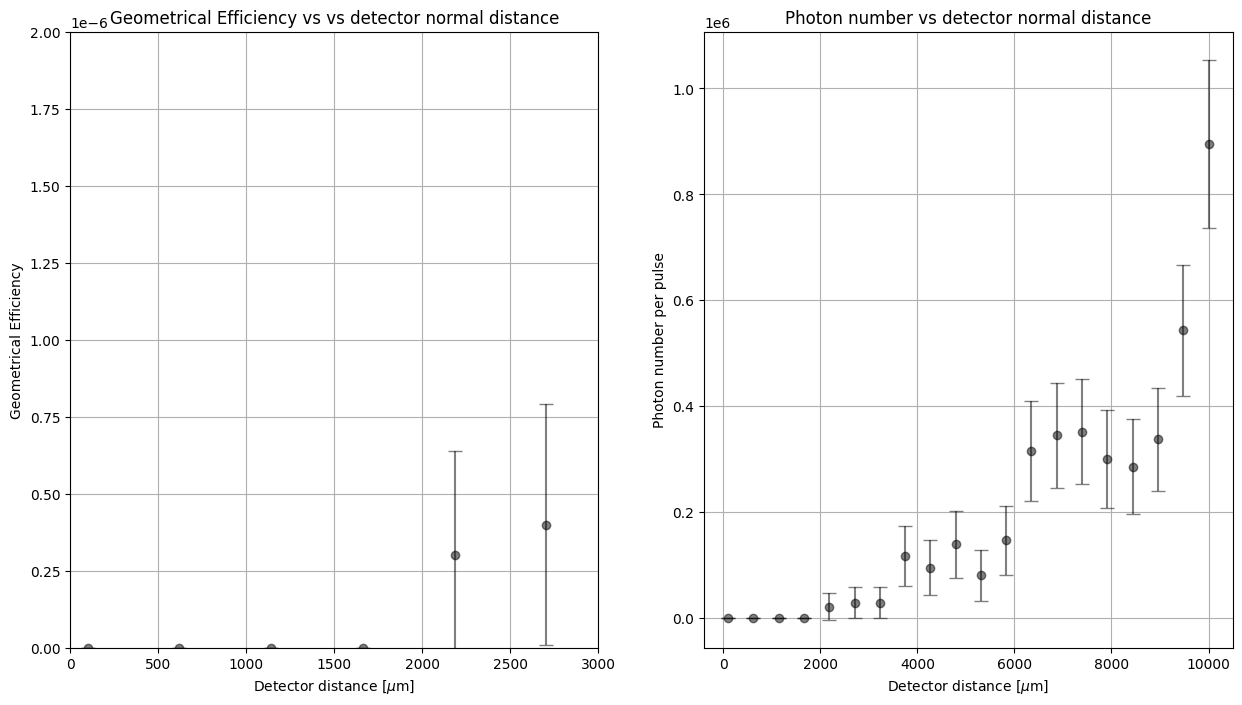

In [17]:
# Plot results

fig, axs = plt.subplots(1,2, figsize=(15,8))
axs[0].errorbar(quote, np.array(eff_means_q), yerr=eff_stds_q, fmt='ko', capsize=5, linestyle='', color='black', alpha=0.5)
axs[0].set_xlabel(r'Detector distance [$\mu$m]')
axs[0].set_ylabel('Geometrical Efficiency')
axs[0].set_title('Geometrical Efficiency vs vs detector normal distance')
axs[0].grid(True)

axs[1].errorbar(quote, np.array(eff_means_q)*I_0, yerr=np.array(eff_stds_q)*I_0, fmt='ko', capsize=5, linestyle='', color='black', alpha=0.5)
axs[1].set_xlabel(r'Detector distance [$\mu$m]')
axs[1].set_ylabel('Photon number per pulse')
axs[1].set_title('Photon number vs detector normal distance')
axs[1].grid(True)
#axs[1].text(-30,0.35*1e6,f'Quota: {distance_to_detector*1e-6} [m]', fontsize='large')
axs[0].set_xlim([0,3000])
axs[0].set_ylim([0,0.2*1e-5])